In [5]:
from word2vec_models import NavecModel

embedding = NavecModel()

In [6]:
from word_processing import Word
from functools import reduce


def word_list_to_vec(word_list: [str]) -> [float]:
    return list(
        reduce(
            lambda result, word: result + list(embedding.word2vec(Word(word))),
            word_list,
            []
        )
    )

In [3]:
from razdel import sentenize, tokenize
from corus import load_librusec


class PositiveCorpus:
    def __init__(self):
        self.window_size = 5
        self.records = load_librusec('/Volumes/UNTITLED/librusec_fb2.plain.gz')

    @staticmethod
    def tokenize_sentence_filter(tokenize_sentence: [str]):
        return list(
            filter(
                lambda x: x not in ',:;()./?!—«»$%@#-+=[]{}',
                tokenize_sentence
            )
        )

    def __iter__(self) -> ([str], float):
        while record := next(self.records):
            text = record.text
            for sentence in sentenize(text):
                tokenized_sentence = self.tokenize_sentence_filter(
                    [token.text.lower() for token in tokenize(sentence.text)]
                )
                while len(tokenized_sentence) >= self.window_size:
                    image = [tokenized_sentence.pop(0) for _ in range(self.window_size)]
                    try:
                        yield word_list_to_vec(image), 1.0
                    except KeyError:
                        pass


positive_count = 100000
positive_corpus = iter(PositiveCorpus())
positive_data = [next(positive_corpus) for _ in range(positive_count)]

In [4]:
from random import choice


class NegativeCorpus:
    def __init__(self):
        self.window_size = 5
        self.predict_batch = 20
        # TODO перенести этот гет в метод модели
        self.vocab = embedding.model.wv.index_to_key

    def __iter__(self) -> ([str], float):
        context = []
        count = 0
        while True:
            if len(context) == self.window_size:
                yield word_list_to_vec(context), 0.0
                context = []
                count += 1
                if count % 500 == 0:
                    print(count)

            if not context:
                context = [choice(self.vocab)]

            # TODO перенести этот гет в метод модели
            context.append(choice(embedding.model.wv.most_similar(context, topn=self.predict_batch))[0])


negative_count = 50000
negative_corpus = iter(NegativeCorpus())
negative_data = [next(negative_corpus) for _ in range(negative_count)]

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500


In [12]:
import os
from settings import DOWNLOADS_PATH

with open(os.path.join(DOWNLOADS_PATH, 'positive_example'), 'w') as f:
    f.write('\n'.join(
        [
            f'{image}|{result}'
            for image, result in positive_data
        ]
    ))

In [13]:
import os
from settings import DOWNLOADS_PATH

with open(os.path.join(DOWNLOADS_PATH, 'negative_example'), 'w') as f:
    f.write('\n'.join(
        [
            f'{image}|{result}'
            for image, result in negative_data
        ]
    ))

In [3]:
def func_chunk(lst, n):
    chunked = []
    for x in range(0, len(lst), n):
        e_c = lst[x : n + x]

        if len(e_c) < n:
            e_c = e_c + [None for y in range(n - len(e_c))]
        chunked.append(np.array(e_c))

    return chunked

In [2]:
import numpy as np
from random import shuffle

all_data = positive_data + negative_data
shuffle(all_data)
train = all_data[:140000]
validation = all_data[140000:]


# TODO оптимизировать
def matrix_to_np_matrix(float_matrix: [[float]]):
    return np.array([np.array(func_chunk(item, 300)) for item in float_matrix])
# TODO оптимизировать
def list_to_np_matrix(float_list: [float]):
    return np.array([np.array([item]) for item in float_list])

x_train, y_train = list(zip(*train))
x_train = matrix_to_np_matrix(x_train)
y_train = list_to_np_matrix(y_train)


x_validation, y_validation = list(zip(*validation))
x_validation = matrix_to_np_matrix(x_validation)
y_validation = list_to_np_matrix(y_validation)

NameError: name 'positive_data' is not defined

In [85]:
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras import Sequential, Input

model = Sequential()
model.add(Conv1D(300, 5, input_shape=(5, 300),activation='elu', padding='same'))
model.add(MaxPooling1D(pool_size=3, padding='same'))
model.add(Conv1D(100, 5, input_shape=(5, 100),activation='elu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [86]:
history = model.fit(x_train, y_train,
                    batch_size=1000,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_validation, y_validation))

Epoch 1/100
140/140 [==============================] - 9s 63ms/step - loss: 0.2205 - accuracy: 0.9348 - val_loss: 0.0942 - val_accuracy: 0.9809
Epoch 2/100
140/140 [==============================] - 9s 62ms/step - loss: 0.0832 - accuracy: 0.9815 - val_loss: 0.0663 - val_accuracy: 0.9871
Epoch 3/100
140/140 [==============================] - 9s 63ms/step - loss: 0.0621 - accuracy: 0.9854 - val_loss: 0.0454 - val_accuracy: 0.9903
Epoch 4/100
140/140 [==============================] - 9s 63ms/step - loss: 0.0441 - accuracy: 0.9890 - val_loss: 0.0370 - val_accuracy: 0.9906
Epoch 5/100
140/140 [==============================] - 9s 63ms/step - loss: 0.0327 - accuracy: 0.9913 - val_loss: 0.0338 - val_accuracy: 0.9908
Epoch 6/100
140/140 [==============================] - 9s 63ms/step - loss: 0.0459 - accuracy: 0.9860 - val_loss: 0.0315 - val_accuracy: 0.9915
Epoch 7/100
140/140 [==============================] - 9s 63ms/step - loss: 0.0301 - accuracy: 0.9914 - val_loss: 0.0281 - val_accuracy:

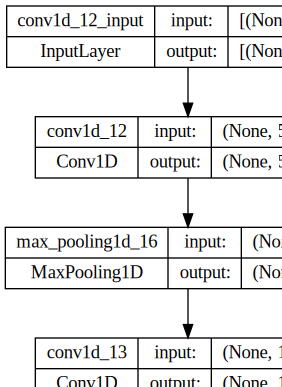

In [67]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

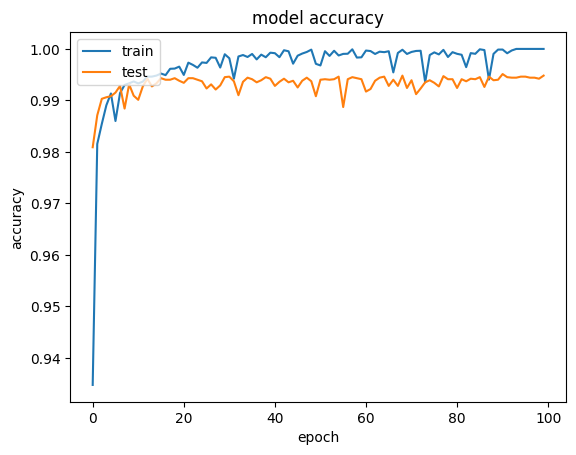

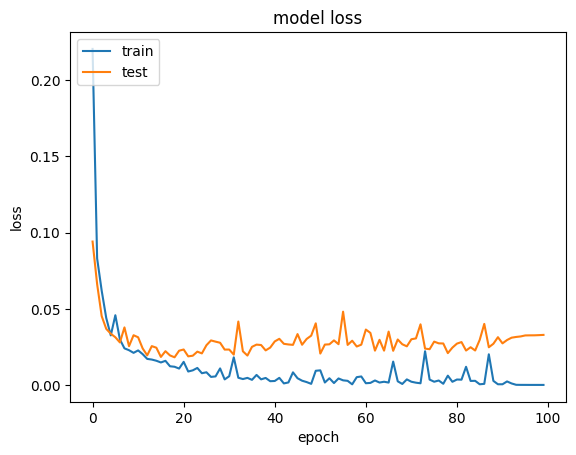

In [87]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
sentence_one = ['кран', 'плыл', 'небом', 'красного', 'песка']
# sentence_one = [choice(NegativeCorpus().vocab) for _ in range(5)]
print(sentence_one)
word2vec_sentence_one = func_chunk(word_list_to_vec(sentence_one), 300)

sentence_two = ['мама', 'мыла', 'раму', 'за', 'окном']
print(sentence_two)
word2vec_sentence_two = func_chunk(word_list_to_vec(sentence_two), 300)

print(word2vec_sentence_one)
# np_sentence = np.array([np.array(word2vec_sentence_one), np.array(word2vec_sentence_two)])
# model.predict(np_sentence)

['кран', 'плыл', 'небом', 'красного', 'песка']


NameError: name 'word_list_to_vec' is not defined

In [92]:
model.save('meaning_classifier.h5')